### Feature Model: ResNet50 - Layer3 - 1024

In questo progetto viene utilizzata una rete neurale pre-addestrata **ResNet50** per estrarre caratteristiche (features) significative dalle immagini. In particolare, si fa uso di un **layer intermedio** della rete, denominato `layer3`.

1. **Ridimensionamento dell'immagine**
   - Ogni immagine viene **ridimensionata a 224×224 pixel**, come richiesto dalla struttura di ResNet50.

2. **Hook sul "layer3"**
   - Si applica un **hook** sull'output del livello `layer3` della ResNet50. Questo layer produce un tensore tridimensionale di forma:
     - 1024 modalità (feature maps)
     - ciascun canale ha dimensioni spaziali 14×14
     - Queste feature rappresentano caratteristiche visive di medio livello, come texture, bordi complessi e forme astratte.

3. **Global Average Pooling**
   -Per convertire il tensore [1024, 14, 14] in un vettore compatto, si applica un **Global Average Pooling**, ovvero: [1024, 14, 14]
   - si calcola la **media** dei valori all'interno di ciascun canale (mappa 14×14)
   - si ottiene così un vettore di **1024 dimensioni**, uno per ogni canale: Feature vector ∈ ℝ¹⁰²⁴

**Perché questo approccio?**
- Il layer `layer3` è sufficientemente profondo da catturare informazioni semantiche utili, ma non troppo da perdere generalità.
- Il vettore da 1024 dimensioni è un buon compromesso tra **ricchezza informativa** e **dimensione gestibile**.
- Queste feature sono adatte per task come:
  - Estrazione di concetti latenti (es. SVD, PCA)
  - Clustering (es. KMeans)
  - Similarità e image retrieval


Import

In [86]:
import os
import cv2
import torch
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision.models as models

from PIL import Image
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis

from torchvision import transforms
from torchvision.models import ResNet50_Weights

from collections import Counter, defaultdict

from sklearn.manifold import TSNE, MDS
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report, pairwise_distances

try:
    import umap
except ImportError:
    print("[WARNING] UMAP non disponibile\n")


### Setup del Modello ResNet50

In questo blocco inizializziamo il modello ResNet50 pre-addestrato su ImageNet. Il modello viene caricato in modalità valutazione (`eval`) e spostato su GPU se disponibile, altrimenti su CPU. Inoltre, viene definito il preprocessing standard usato per l'inferenza, basato sui parametri di normalizzazione ImageNet.


In [87]:
# Se CUDA disponibile, usa la GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carica ResNet50 pre-addestrata e in modalità eval
weights = ResNet50_Weights.IMAGENET1K_V1  # o DEFAULT per i pesi più aggiornati
model = models.resnet50(weights=weights)
model.eval()
model.to(device)

# Preprocessing standard per ResNet
preprocess = weights.transforms()

### Preprocessing delle Immagini

Questa funzione carica un'immagine da un percorso specifico e applica le trasformazioni richieste per essere compatibile con ResNet50. In particolare, le immagini vengono ridimensionate, ritagliate al centro e normalizzate con le statistiche di ImageNet. Il risultato è un tensore PyTorch pronto per l’inferenza.


In [88]:
# Funzione per caricare l'immagine e fare la pre-elaborazione
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

### Estrazione delle Feature da un’Immagine

Questa funzione combina il preprocessing e l’estrazione delle feature. Una volta preprocessata, l’immagine viene passata attraverso il modello, e viene calcolata la media delle attivazioni spaziali su ogni canale. Questo produce un vettore di feature compatto, che rappresenta l'immagine in uno spazio semantico.


In [89]:
# Funzione per estrarre la media su ciascuna mappa di attivazione
def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model, device)
    features_vector = features.mean(dim=(1, 2)).cpu().numpy()  # [1024]
    return features_vector

### Caricamento delle Feature Estratte

Questa funzione carica da disco i vettori di feature, le etichette e i nomi dei file associati, precedentemente salvati in un file `.npz`. Vengono caricati due insiemi di dati, corrispondenti a Part1 e Part2. Questi saranno utilizzati per analisi comparative nei task successivi.


In [90]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])

feat_matrix_part2, lbls_part2, flname_part2 = load_features("resnet_features_part2.npz")
feat_matrix_part1, lbls_part1, flname_part1 = load_features("resnet_features_part1.npz")

## Task 1-2
Implementa un programma che estrae e memorizza i descrittori di feature per tutte le immagini nel set di dati  

#### Estrazione delle Feature dal Livello `layer3` della ResNet50
Questa funzione estrae le feature intermedie da un'immagine passata al modello, utilizzando un hook di PyTorch sul primo modulo del blocco `layer3` di ResNet50. 

#### Obiettivo
Intercettare l'output del **primo blocco residuo** di `layer3` (ossia `layer3[0]`) per ottenere un tensore tridimensionale con forma `[1024, 14, 14]`, rappresentante le feature visive di medio livello.

In [91]:
# Funzione per estrarre le caratteristiche dal livello "layer3" della ResNet
def extract_resnet_features(img_tensor, model, device):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor.to(device))
    hook.remove()

    fmap = hook_fn.features.squeeze(0)  # [1024, 14, 14]
    return fmap  # Tensor, non numpy!

### Estrazione e Salvataggio delle Feature da Cartelle di Immagini

Questa funzione processa immagini distribuite in diverse sottocartelle all’interno di una directory base. Per ogni immagine valida, estrae il vettore di feature utilizzando la pipeline definita in `extract_and_process_image`. 

I vettori di feature, insieme ai nomi dei file e alle etichette (nomi delle sottocartelle), vengono salvati in un file `.npz` per un utilizzo efficiente nei task successivi.

La funzione fornisce messaggi di log per monitorare il progresso e segnala eventuali errori o cartelle mancanti.

In [92]:
def process_and_save_features(base_folder, subfolders, output_file):
    all_features = []
    all_filenames = []
    all_labels = []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        if not os.path.isdir(folder_path):
            print(f"[ATTENZIONE] Cartella non trovata: {folder_path}")
            continue
        print(f"[INFO] Elaboro cartella: {label}")

        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_and_process_image(img_path, model)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)
                else:
                    print(f"[ERRORE] Feature non estratte da {img_path}")

    # Salva in file .npz
    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    
    print(f"[SALVATO] Features salvate in {output_file}")
    print(f"[FINE] Totale immagini processate: {len(all_features)}")

Memorizzazione 

In [93]:
# Parametri cartelle e output
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "resnet_features_part1")
process_and_save_features("Part2", subfolders, "resnet_features_part2")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part1
[FINE] Totale immagini processate: 3006
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in resnet_features_part2
[FINE] Totale immagini processate: 3006


In [94]:
def activation_map(fmap, n_maps=4):
    fig, axs = plt.subplots(1, n_maps, figsize=(4*n_maps, 4))
    for i in range(n_maps):
        axs[i].imshow(fmap[i].cpu().numpy(), cmap='viridis')
        axs[i].set_title(f'Activation map #{i}')
        axs[i].axis('off')
    plt.suptitle("Esempio mappe di attivazione (Layer3)")
    plt.show()

In [95]:
img_tensor = preprocess_image(img_path)
fmap = extract_resnet_features(img_tensor, model, device)  # [1024, 14, 14]


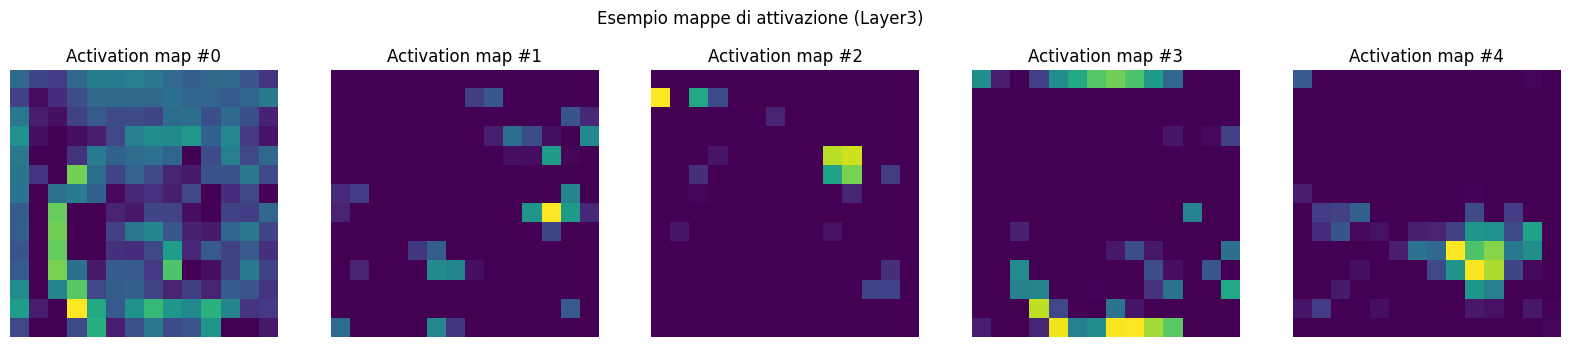

In [96]:
activation_map(fmap, n_maps=5)

In [97]:
def plot_feature_vector(fmap):
    """
    Plotta il vettore di feature finale [1024] ottenuto facendo la media su 14x14 di ciascun canale.
    """
    # Calcola la media
    features_vector = fmap.mean(dim=[1, 2]).cpu().numpy()

    # Crea il plot
    plt.figure(figsize=(12, 4))
    plt.plot(features_vector)
    plt.title("Feature vector ResNet-Layer3-1024 (mean 14x14 per channel)")
    plt.xlabel("Feature index")
    plt.ylabel("Mean activation")
    plt.show()


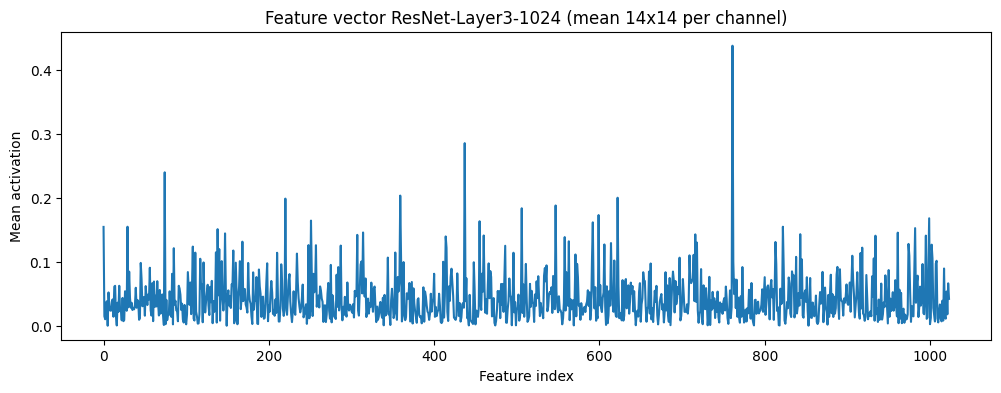

In [98]:
plot_feature_vector(fmap)

# Task 3:

 Implementa un programma che, dato il nome di un file immagine e un valore "k", restituisce e visualizza le k immagini più simili in base a ciascun modello visivo - selezionerai l'appropriata misura di distanza/similarità per ciascun modello di feature.  Per ogni corrispondenza, elenca anche il corrispondente punteggio di distanza/similarità. 

  *Retrieval: Immagini più Simili (distanza coseno & eclidea)* 

---

### Metodo

1. **Estrazione delle feature**
   - Le feature dell’immagine di query vengono estratte usando il modello `ResNet50-layer3`, già descritto nel Task precedente.
   - Anche le feature del dataset di immagini (già estratte in precedenza) vengono caricate.

2. **Scelta della metrica**
   - Poiché lo spazio delle feature è vettoriale, si utilizza una **metrica di distanza** adatta:
     - In questo caso, si usa la **distanza euclidea** oppure la **cosine similarity** per confrontare i vettori.

3. **Calcolo delle similarità**
   - Per ogni immagine nel dataset, si calcola la distanza (o similarità) rispetto alla query.
   - Si ordinano le immagini in base alla distanza crescente (o similarità decrescente).
   - Si selezionano le top-`k`.

4. **Visualizzazione**
   - Si mostra l’immagine di query seguita dalle `k` immagini più simili.
   - Sotto ogni immagine simile viene indicato il relativo **punteggio di similarità/distanza**.

---

### Output previsto

- Una riga di immagini:
  - La prima è la **query**
  - Le successive sono le **k immagini più simili**
- Sotto ogni immagine simile compare la distanza/similarità

---

### Funzione di Retrieval: Trovare le \(k\) Immagini Più Simili

Questa funzione implementa il sistema di retrieval delle immagini più simili rispetto a una immagine di query, utilizzando due diverse metriche di confronto:

- **Distanza Euclidea**: misura la distanza geometrica tra il vettore di feature della query e quelli del dataset. Immagini con valori di distanza minori sono considerate più simili.
- **Similarità Coseno**: misura l’angolo tra i vettori, indicando quanto sono orientati nella stessa direzione. Valori più alti indicano una maggiore similarità.

La funzione estrae la feature dell’immagine query tramite il modello ResNet, calcola la distanza o similarità con tutte le feature del dataset, ordina i risultati e visualizza le prime \(k\) immagini più simili, con i rispettivi punteggi.

Il confronto è effettuato sulle feature pre-calcolate contenute nel file `.npz`, e la visualizzazione mostra anche i nomi dei file e i valori di distanza o similarità.


In [109]:
def find_top_k_similar(query_img_path, k, model, image_folder, metric):

    # Estrai feature per immagine query
    query_feature = extract_and_process_image(query_img_path, model).reshape(1, -1)

    # Calcola similarità/distanza
    if metric == "euclidean":
        res = np.linalg.norm(feat_matrix_part1 - query_feature, axis=1)
        bad_value = np.inf  # penalizza immagini identiche
    elif metric == "cosine":
        res = cosine_similarity(query_feature, feat_matrix_part1)[0]
        bad_value = -np.inf  # penalizza immagini identiche
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

    # Escludi la query se è nel dataset
    query_filename = os.path.basename(query_img_path)
    query_label = os.path.basename(os.path.dirname(query_img_path))
    for i in range(len(flname_part1)):
        if flname_part1[i] == query_filename and lbls_part1[i] == query_label:
            res[i] = bad_value
            break

    # Ordina in base alla metrica
    if metric == "euclidean":
        top_k_indices = np.argsort(res)[:k]  # più vicino = meglio
    else:  # cosine
        top_k_indices = np.argsort(res)[::-1][:k]  # più simile = meglio

    # Visualizzazione
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(
            image_folder, lbls_part1[idx], flname_part1[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if metric == "euclidean":
            plt.title(f"{flname_part1[idx]}\nDist: {res[idx]:.4f}")
        else:
            plt.title(f"{flname_part1[idx]}\nSim: {res[idx]:.4f}")

    plt.suptitle(f"Top-{k} immagini più simili ({metric})")
    plt.tight_layout()
    plt.show()

    top_k_paths = [
        os.path.join(image_folder, lbls_part1[idx], flname_part1[idx])
        for idx in top_k_indices
    ]
    top_k_scores = res[top_k_indices]
    top_k_filenames = [flname_part1[idx] for idx in top_k_indices]

    return top_k_paths, top_k_scores, top_k_filenames

### Esecuzione del Retrieval con Parametri Specifici

In questa sezione impostiamo i parametri per eseguire il retrieval delle immagini simili:

- **Immagine di Query**: `brain_tumor_0001.jpg`, appartenente alla categoria `brain_tumor`.
- **k = 5**: numero di immagini simili da recuperare.
- **Cartella Immagini**: `Part1`, la directory base contenente le immagini organizzate in sottocartelle per categoria.

Viene poi effettuata la chiamata alla funzione `find_top_k_similar`, utilizzando la **distanza euclidea** oppure la **cosine similarity**.

Questa sezione consente di confrontare visivamente i risultati ottenuti con le due diverse metriche, valutando quale produce immagini semanticamente più simili rispetto alla query.

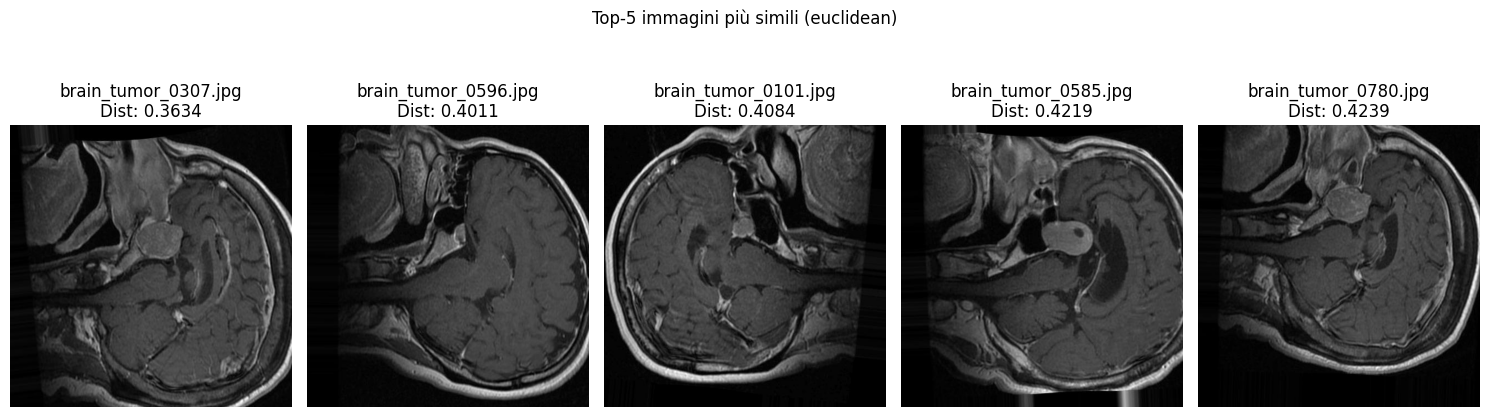

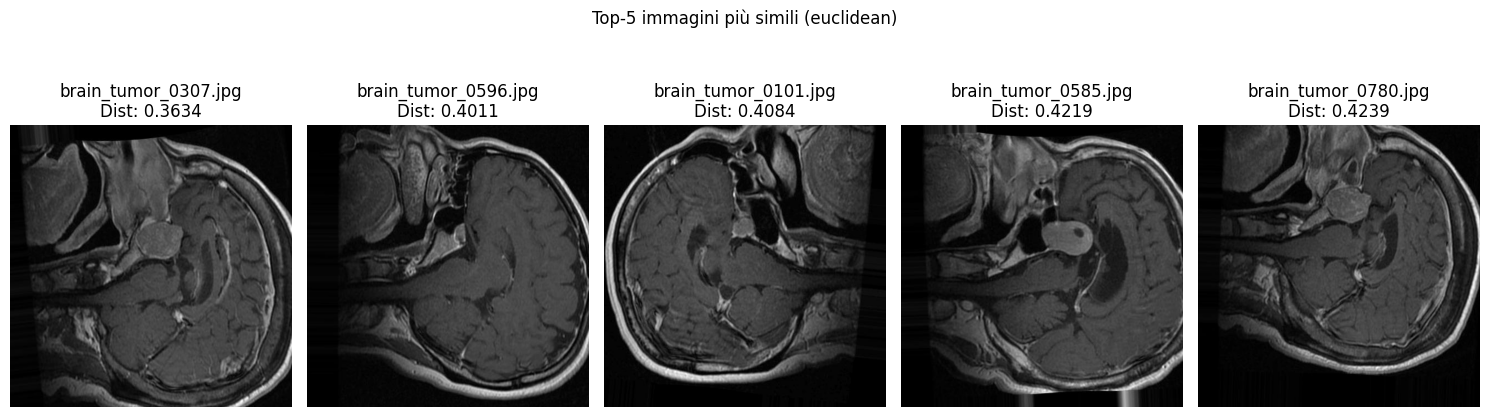

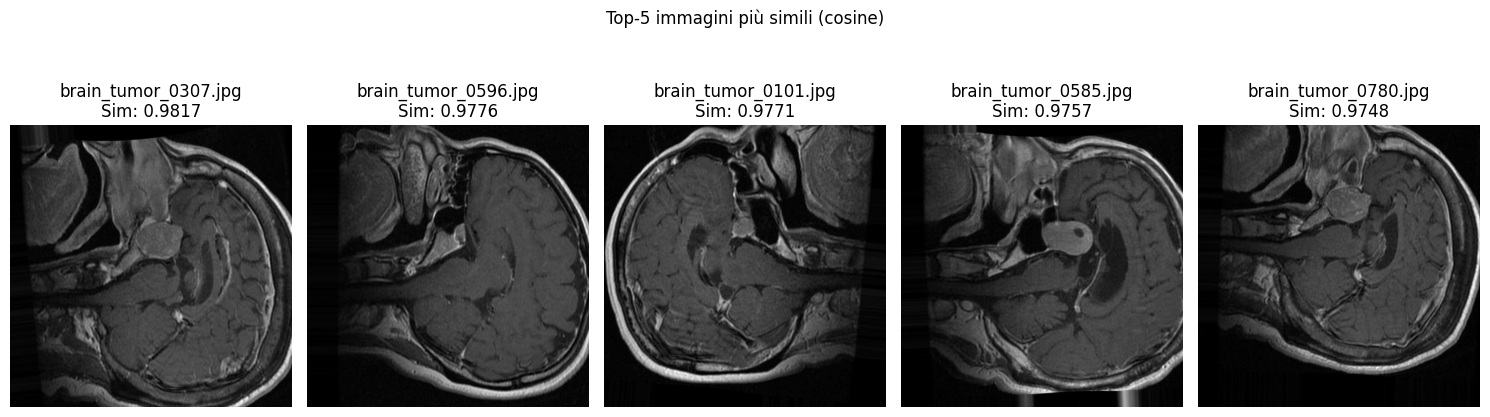

(['Part1/brain_tumor/brain_tumor_0307.jpg',
  'Part1/brain_tumor/brain_tumor_0596.jpg',
  'Part1/brain_tumor/brain_tumor_0101.jpg',
  'Part1/brain_tumor/brain_tumor_0585.jpg',
  'Part1/brain_tumor/brain_tumor_0780.jpg'],
 array([0.98174083, 0.9775667 , 0.9770521 , 0.97573996, 0.97475886],
       dtype=float32),
 [np.str_('brain_tumor_0307.jpg'),
  np.str_('brain_tumor_0596.jpg'),
  np.str_('brain_tumor_0101.jpg'),
  np.str_('brain_tumor_0585.jpg'),
  np.str_('brain_tumor_0780.jpg')])

In [110]:
query_img_path = "Part1/brain_tumor/brain_tumor_0001.jpg"
k = 5
base_folder = "Part1"

# Parametri
query_img_path = "Part1/brain_tumor/brain_tumor_0001.jpg"
k = 5
base_folder = "Part1"
metric = "euclidean"

# Trova top-k
top_k_paths, top_k_scores, top_k_filenames = find_top_k_similar(
    query_img_path, k, model, base_folder, metric
)

find_top_k_similar(query_img_path, k, model, base_folder, metric="euclidean") # Distanza Euclidea
find_top_k_similar(query_img_path, k, model, base_folder, metric="cosine") # Cosine Similarity

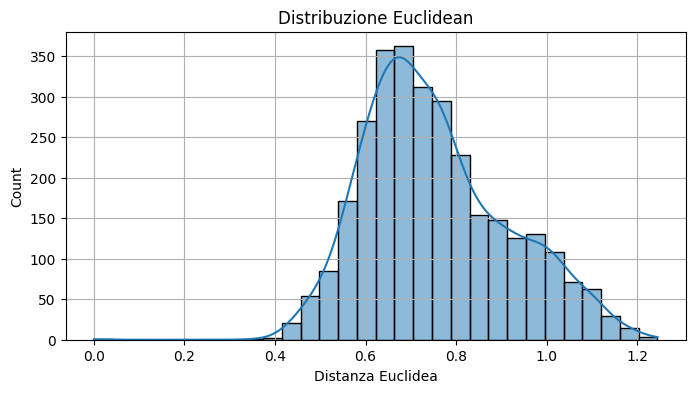

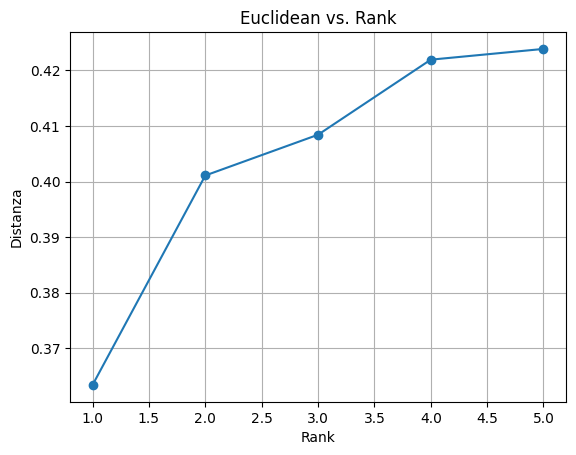

In [117]:
# Distribuzione punteggi
plt.figure(figsize=(8, 4))
if metric == "euclidean":
    sns.histplot(np.linalg.norm(feat_matrix_part1 - extract_and_process_image(query_img_path, model).reshape(1, -1), axis=1), bins=30, kde=True)
    plt.xlabel("Distanza Euclidea")
else:
    all_sims = cosine_similarity(extract_and_process_image(query_img_path, model).reshape(1, -1), feat_matrix_part1)[0]
    sns.histplot(all_sims, bins=30, kde=True)
    plt.xlabel("Similarità Coseno")
plt.title(f"Distribuzione {metric.capitalize()}")
plt.grid(True)
plt.show()

# Rank plot
plt.plot(range(1, k + 1), top_k_scores if metric == "euclidean" else sorted(top_k_scores, reverse=True), marker='o')
plt.title(f"{metric.capitalize()} vs. Rank")
plt.xlabel("Rank")
plt.ylabel("Distanza" if metric == "euclidean" else "Similarità")
plt.grid(True)
plt.show()

# Task 4:

Implementa un programma che, dati (a) un file immagine di query della parte 2, (b) uno spazio di feature selezionato dall'utente e (c) un numero intero positivo k (k<=2), identifica ed elenca le k etichette di corrispondenza più probabili, insieme ai loro punteggi, nello spazio di feature selezionato.

---

### Metodo

1. **Estrazione delle Feature**

2. **Rappresentazione del Dataset Etichettato**

3. **Calcolo delle Distanze/Similarità**
   - Per misurare quanto la query è vicina alle immagini di ciascuna classe, si calcolano metriche di distanza o similarità tra il vettore query e i vettori delle immagini nel dataset.
   - Le metriche considerate, che performano meglio con ResNet, sono:
     - **Distanza Euclidea** (norma L2)
     - **Cosine Similarity** (misura l’angolo tra vettori)

4. **Aggregazione dei Punteggi per Etichetta**

   Due strategie di aggregazione sono state implementate:

    - **Strategia 1: Media delle distanze/similarità**
       - Per ogni classe, si calcolano tutte le distanze (o similarità) tra la query e le immagini di quella classe.
       - Si prende la media di questi valori come punteggio rappresentativo della classe.

    - **Strategia 2: Distanza dal prototipo (centroide)**
       - Si calcola il vettore prototipo (centroide) di ciascuna classe come media dei vettori delle sue immagini.
       - Si misura la distanza o similarità tra la query e ciascun prototipo.

5. **Selezione delle Etichette Predette**
   - Le classi vengono ordinate in base al punteggio calcolato (distanza crescente o similarità decrescente).
   - Si selezionano le prime `k` classi come etichette più probabili.

### Output atteso

La funzione esegue due strategie diverse e stampa, per ognuna:

- Le **k etichette più simili** (cioè più vicine alla query nel feature space)
- Un **punteggio** associato a ciascuna etichetta:
  - **Distanza media** dalla query verso le immagini della classe
  - **Distanza dal prototipo** (centroide) della classe

In [ ]:
# Calcola la distanza o similarità tra la feature della query e un insieme di feature target.
# Supporta sia distanza euclidea che similarità coseno.
def compute_metric(query_feat, target_feats, metric):
    query_feat = query_feat.reshape(1, -1)
    if metric == "euclidean":
        return np.linalg.norm(target_feats - query_feat, axis=1)
    elif metric == "cosine":
        return cosine_similarity(query_feat, target_feats)[0]
    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")


# Per ogni etichetta si calcola la media delle distanze tra la query e tutte le immagini della classe.
# Le top-k etichette con la distanza media più bassa (o similarità più alta) vengono selezionate.
def predict_top_k_labels_distance_mean(query_img_path, k, model, metric):
    query_feat = extract_and_process_image(query_img_path, model)
    unique_labels = np.unique(lbls_part1)
    avg_scores = []
    for label in unique_labels:
        class_feats = feat_matrix_part1[lbls_part1 == label]
        scores = compute_metric(query_feat, class_feats, metric)
        avg_scores.append(scores.mean())
    if metric == "euclidean":
        sorted_indices = np.argsort(avg_scores)
    else:  # cosine
        sorted_indices = np.argsort(avg_scores)[::-1]
    print(f"--- Top-{k} etichette - Distanza media ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score medio: {avg_scores[idx]:.4f}")


# Per ogni etichetta si calcola il prototipo (media dei vettori feature),
# poi si misura la distanza o similarità tra la query e ogni prototipo.
def predict_top_k_labels_prototype(query_img_path, k, model, metric):
    query_feat = extract_and_process_image(query_img_path, model)
    unique_labels = np.unique(lbls_part1)
    prototypes = []
    for label in unique_labels:
        class_feats = feat_matrix_part1[lbls_part1 == label]
        prototypes.append(class_feats.mean(axis=0))
    prototypes = np.vstack(prototypes)
    scores = compute_metric(query_feat, prototypes, metric)
    if metric == "euclidean":
        sorted_indices = np.argsort(scores)
    else:
        sorted_indices = np.argsort(scores)[::-1]
    print(f"--- Top-{k} etichette - Prototipo classe ({metric}) ---")
    for i in range(min(k, len(unique_labels))):
        idx = sorted_indices[i]
        print(f"{unique_labels[idx]} \t Score: {scores[idx]:.4f}")


# Dato un'immagine di query, un valore k e una metrica, stampa le top-k etichette predette
# usando entrambe le strategie: distanza media o cosine similarty.
def task4_predict_labels(query_img_path, k, model, metric):
    assert k <= 2, "k deve essere <= 2"
    print(f"Predizione top-{k} per immagine '{query_img_path}' usando metrica '{metric}'")
    predict_top_k_labels_distance_mean(query_img_path, k, model, metric)
    print()
    predict_top_k_labels_prototype(query_img_path, k, model, metric)

Esecuzione

In [ ]:
query_img = "Part2/brain_glioma/brain_glioma_1112.jpg"

task4_predict_labels(query_img, k=2, model=model, metric="euclidean")

task4_predict_labels(query_img, k=2, model=model, metric="cosine")

## Task 5

Implementa un programma che:<br>
(a) dato uno dei modelli di feature,<br> 
(b) un valore k specificato dall'utente, <br>
(c) una delle tre tecniche di riduzione della dimensionalità (SVD, LDA, k-means) scelte dall'utente,<br> 
riporta le prime k semantiche latenti estratte nello spazio di feature selezionato.    

- Memorizza le semantiche latenti in un file di output adeguatamente nominato.    

- Elenca le coppie imageID-peso, ordinate in ordine decrescente di pesi.    



### Metodologia

1. **Input**
   - Viene fornito un file `.npz` che contiene le feature estratte dalle immagini (`feature_model_path`).
   - Si sceglie una delle seguenti tecniche:
     - `"svd"`: Singular Value Decomposition
     - `"lda"`: Linear Discriminant Analysis
     - `"kmeans"`: Clustering KMeans
   - Si specifica un numero `k` di concetti latenti da estrarre.

2. **Trasformazione**
   - Le feature originali vengono proiettate in uno spazio latente a `k` dimensioni.
   - Vengono calcolati i **pesi** (coefficenti di proiezione o distanze) associati a ciascuna immagine rispetto a ogni componente o cluster.

3. **Ordinamento e Interpretazione**
   - Per ogni concetto latente, le immagini vengono ordinate in base al peso assoluto (quanto "rappresentano" quel concetto).
   - Questo permette di individuare le immagini più emblematiche per ogni componente/cluster.

4. **Visualizzazione**
   - Se possibile, i dati trasformati vengono visualizzati in 2D (es. primi 2 componenti) con colorazione per classe.

5. **Salvataggio dei Risultati**
   - I risultati vengono salvati in un file di testo:
     ```
     latent_semantics_<tecnica>_<nome_feature_model>_k<k>.txt
     ```
   - Per ogni concetto latente viene elencata una lista ordinata di immagini con:
     - Nome file
     - Peso
     - Classe

In [ ]:
# Visualizza la proiezione 2D dello spazio latente.
def plot_latent_space_2d(X_transformed, labels, technique, k):
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

#Visualizza i cluster KMeans in 2D usando SVD per proiezione.
def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):    
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

In [ ]:
# La funzione applica una tecnica di riduzione dimensionale (SVD, LDA, KMeans)
# sullo spazio delle feature estratte da ResNet e salva su file le feature latenti ottenute.
def task5_latent_semantics_resnet(feature_model_path, technique, k):
    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k, random_state=42)
        X_transformed = model.fit_transform(feat_matrix_part1)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(lbls_part1)
        max_k = len(unique_labels) - 1
        if k > max_k:
            print(f"Warning: LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feat_matrix_part1, lbls_part1)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feat_matrix_part1)
        components = model.cluster_centers_
        X_transformed = model.transform(feat_matrix_part1)
        method = "kmeans"
    else:
        print("Error: Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # === Visualizzazione ===
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, lbls_part1, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feat_matrix_part1, lbls_part1, k)
    
    # === Output file ===
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feat_matrix_part1 @ components[i].T
            else:
                weights = -X_transformed[:, i]  # distanza inversa

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{flname_part1[idx]} | Peso: {weights[idx]:.4f} | Classe: {lbls_part1[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

Test

In [ ]:
# Supponendo tu abbia salvato il file .npz come "resnet_layer3.npz"
task5_latent_semantics_resnet("resnet_features_part1.npz", technique="svd", k=5)
task5_latent_semantics_resnet("resnet_features_part1.npz", technique="lda", k=2)
task5_latent_semantics_resnet("resnet_features_part1.npz", technique="kmeans", k=6)

### Task 6:

### Task 6a
Implementa un programma che calcola e stampa la "inherent dimensionality" associata alle immagini della parte 1.    

### Metodo utilizzato

Il calcolo si basa su:
- L’Analisi delle Componenti Principali (PCA)
- Si esegue una decomposizione con TruncatedSVD o PCA sul dataset feat_matrix_part1
- Si osserva il cumulative explained variance ratio

### Obiettivo: 
 - [SVD] Varianza spiegata cumulativa (95%): raggiunta con 87 componenti
 - [SVD] Varianza spiegata cumulativa (99%): raggiunta con 156 componenti

In [ ]:
def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_   
    cumulative = np.cumsum(explained)

    if threshold >= 1.0:
        intrinsic_dim = len(cumulative)
    else:
        intrinsic_dim = np.argmax(cumulative >= threshold) + 1
    
    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values

### Task 6b: 
Implementa un programma che calcola e stampa la "dimensionalità intrinseca" (numero di dim indipendenti minime necassari per rappresentare set) associata a ciascuna etichetta univoca delle immagini della parte 1.  

In [ ]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map

Test

In [ ]:
print("\nStima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)

print("\nTask 6a - Dimensionalità instrinsca dell'insieme di img Part1")
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=1.00, plot=True)

print("\n Task 6b - Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=1.00)

# Task 7:

Implementa un programma che,per ciascuna etichetta univoca l, calcola le corrispondenti k semantiche latenti (a tua scelta) associate alle immagini della parte 1, e per le immagini della parte 2, prevede le etichette più probabili utilizzando distanze/similarità calcolate sotto le semantiche latenti specifiche dell'etichetta.
Il sistema dovrebbe anche fornire valori di precision, recall, and F1-score per etichetta, nonché un valore di accuratezza complessiva.   

### Metodo

1. **Costruzione degli spazi latenti per etichetta**:
   - Per ogni classe, estraiamo tutte le immagini della parte 1 che la rappresentano.
   - Applichiamo **StandardScaler** per normalizzare le feature.
   - Eseguiamo una **SVD** su ogni sottoinsieme per ottenere `k` concetti latenti.
   - Calcoliamo la **media (centroide)** dei vettori latenti ottenuti.

2. **Predizione su immagini della parte 2**:
   - Ogni immagine viene trasformata nello spazio latente di ogni classe.
   - Calcoliamo la **distanza euclidea** tra la rappresentazione latente dell'immagine e il centroide della classe.
   - L’etichetta predetta è quella con distanza minima.

3. **Valutazione delle predizioni**:
   - Calcoliamo metriche di classificazione: **precision, recall, F1-score per classe**.
   - Calcoliamo anche l’**accuracy complessiva**.

In [ ]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD
    
        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred

def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))

def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [ ]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

## Task 8
Implementa un programma che, per ciascuna etichetta univoca l, calcola i corrispondenti c cluster più significativi associati alle immagini della parte 1 (utilizzando l'algoritmo DBScan); <br> i cluster risultanti devono essere visualizzati sia come nuvole di punti colorate in modo diverso in uno spazio MDS a 2 dimensioni, sia come gruppi di miniature di immagini.

#### Obiettivo del Task
In questo task esploriamo la **struttura interna dei dati di ciascuna classe**, cercando di identificare eventuali **cluster naturali** (gruppi di immagini statisticamente simili) all’interno delle feature.

Per farlo combiniamo due tecniche fondamentali:
- Dimensionality Reduction (PCA, UMAP).
- **DBSCAN:** per identificare cluster basati sulla densità dei punti nello spazio delle feature.

---
#### **Metodo utilizzato**

##### 1️ - **Riduzione dimensionale**
- Prima di applicare il clustering, riduciamo lo spazio delle feature da 900 a **50 componenti**, mantenendo la maggior parte della varianza.
- La riduzione aiuta DBSCAN a lavorare meglio, eliminando il rumore di alta dimensionalità.
<br>Metodi:<br>
    - **PCA (Principal Component Analysis)**: proietta i dati lungo le direzioni di massima varianza, preservando la struttura lineare globale.
    - **UMAP (Uniform Manifold Approximation and Projection)**: preserva sia la struttura locale che globale, più veloce e scalabile rispetto a t-SNE.


#### 2️ **Clustering con DBSCAN**
**DBSCAN** (Density-Based Spatial Clustering of Applications with Noise):
- Identifica i cluster come gruppi di punti vicini tra loro.
- I punti che non appartengono a nessun cluster vengono etichettati come **rumore (-1)**.

Parametri principali utilizzati:
 - **eps**             Raggio di vicinanza per considerare due punti vicini     2.0
 - **min_samples**     Minimo numero di punti per formare un cluster            3

#### 3️ **Selezione dei cluster più significativi**
Dopo aver identificato tutti i cluster, selezioniamo gli **'n' cluster più popolosi** per ciascuna classe, escludendo il rumore.

#### 4️ **Visualizzazione dei risultati**
Abbiamo rappresentato i risultati in due modi:
- **MDS 2D (Multidimensional Scaling)** 
- **Griglie di immagini**

In [ ]:
# Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method='pca', n_components=50, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError("Metodo non supportato")
    reduced = reducer.fit_transform(features)
    return reduced

# Applichiamo DBSCAN
def apply_dbscan(features, eps=2.5, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(features)
    return labels

# Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    counts = Counter(cluster_labels)
    counts.pop(-1, None)  # Rimuovi rumore
    top = [lbl for lbl, _ in counts.most_common(c)]
    return top

# Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds(features, cluster_labels, top_clusters, metric='euclidean'):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(features)
    D = pairwise_distances(scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, n_init=4)  # 👈 Fix qui
    Y = mds.fit_transform(D)

    cmap = plt.get_cmap('tab10')

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl) % 10
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30)
        else:
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.show()


# Miniature
def show_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    for cluster_id in top_clusters:
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        n_show = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(n_show)))
        plt.figure(figsize=(n*2, n*2))
        for j, idx in enumerate(idxs[:n_show]):
            img = Image.open(images[idx]).convert('RGB').resize(thumb_size)
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini")
        plt.show()

# MAIN 
def dbscan_per_label(
    features_all, labels_all, filenames_all,
    eps=2.5, min_samples=5, n_components=50, method='pca', c=3
):
    base_folder = "Part1"
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(filenames_all, labels_all)]

    unique_labels = np.unique(labels_all)

    for lbl in unique_labels:
        print(f"\n=== Label: {lbl} ===")
        mask = (labels_all == lbl)
        features_lbl = features_all[mask]
        images_lbl = np.array(images_full)[mask]

        reduced = reduce_features(features_lbl, method=method, n_components=n_components)
        scaled = StandardScaler().fit_transform(reduced)
        cluster_labels = apply_dbscan(scaled, eps=eps, min_samples=min_samples)
        print(f"Trovati cluster: {np.unique(cluster_labels)}")

        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"Top {c} cluster: {top_clusters}")

        plot_mds(features_lbl, cluster_labels, top_clusters)
        show_thumbnails(images_lbl, cluster_labels, top_clusters)


In [ ]:
dbscan_per_label(
    features_all=feat_matrix_part1,
    labels_all=lbls_part1,
    filenames_all=flname_part1,
    eps=7,
    min_samples=3,
    n_components=50,
    method='pca',   # oppure 'umap'
    c=3
)

In [ ]:
#Applichiamo tecniche di dimensionality reduction
def reduce_features(features, method, n_components, random_state=42):
    if method == "pca":
        reducer = PCA(n_components=n_components)
    elif method == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=random_state)
    else:
        raise ValueError(f"Metodo di riduzione '{method}' non supportato.")

    return reducer.fit_transform(features)

#Applichiamo una tecnica di riduzione mediante reduce_feature alle features di partenza ottenendo la lista di Feature Latenti
#Applichiamo su insieme di feature latenti StandardScaler per cercare di ottenere migliori cluster tramite DBSCAN

def apply_dbscan_with_pca(features, eps, min_samples, n_components, method):
    print(f"Applicazione di {method} -> Riduzione a {n_components} componenti")
    reduced_features = reduce_features(features, method, n_components=n_components)
    
    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels

#Calcola i 'c' cluster di maggior cardinalità
def top_c_clusters(cluster_labels, c):
    label_counts = Counter(cluster_labels)
    label_counts.pop(-1, None) # rimozione cluster catalogato come rumore (-1)
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i 'c' cluster più frequenti
    most_common = label_counts.most_common(c)
    top = [int(lbl) for lbl, _ in most_common]
    
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


#Applichiamo al risultato di DBSCAN l'algoritmo di MDS
def plot_mds_clusters(features, cluster_labels, top_clusters, metric):
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    #Generazione di una nuova matrice basata sul parametro metric (es. 'cosine')
    D = pairwise_distances(features_scaled, metric=metric)
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    Y = mds.fit_transform(D)

    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)
    
    plt.title(f"MDS 2D - Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()

#Genera blocco di immagini trovate per cluster
def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16-25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)
            
            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()

In [ ]:
#main
def db_scan_detection(eps, min_samples, n_components, c, method):

    # Costruisce l’elenco dei full path per tutte le immagini
    base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
    images_full = [os.path.join(base_folder, lbl, fname) for fname, lbl in zip(flname_part1, lbls_part1)]

    # Scorre ogni label di Parte1 ed applico DBSCAN+PCA
    unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

    for lbl in unique_labels:
        print(f"\n============================")
        print(f"[INFO] Elaboro label: {lbl}")
        print(f"==============================")

        #Estrae le righe di feat_matrix_part1 / flname_part1 corrispondenti
        mask_lbl = (lbls_part1 == lbl)
        features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
        images_label = np.array(images_full)[mask_lbl]

        #Chiama la tua funzione PCA + DBSCAN
        cluster_labels = apply_dbscan_with_pca(
            features_label,
            eps=eps,
            min_samples=min_samples,
            n_components=n_components,
            method = method
        )
        print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

        # Trova i c cluster più grandi
        top_clusters = top_c_clusters(cluster_labels, c)
        print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

        # MDS‐2D + scatter plot del clustering
        print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")

        plot_mds_clusters(
            features_label,
            cluster_labels,
            top_clusters,
            metric='euclidean'
        )

        # Creo le miniature di ogni cluster “significativo”
        print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
        show_cluster_thumbnails(
            images_label,      # array di stringhe di percorsi
            cluster_labels,    # array di int di lunghezza n_i
            top_clusters,      # la lista dei c indici di cluster
            thumb_size=(64, 64)
        )

    print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")

In [ ]:
eps = 5.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label
method = 'pca'      # umap or pca
db_scan_detection(eps, min_samples, n_components, c, method)

### Task 9
Implementa un programma che, dati le immagini della parte 1:
 - crea un classificatore m-NN (per una m specificata dall'utente),
 - crea un classificatore ad albero decisionale,<br>
Per questo task, puoi utilizzare lo spazio delle feature di tua scelta.<br>
Per le immagini della parte 2, prevede le etichette più probabili utilizzando il classificatore selezionato dall'utente.<br>
Il sistema dovrebbe anche fornire valori di precisione, richiamo e punteggio F1 per etichetta, nonché un valore di accuratezza complessiva.    

#### **Obiettivo del Task**
In questo task testiamo due approcci di **classificazione supervisionata**, usando come feature i **Color Moments** estratti in precedenza.  
L’obiettivo è **prevedere la classe** di ciascuna immagine del dataset **Parte 2**, dopo aver addestrato i classificatori sulla **Parte 1**.


#### **Classificatori utilizzati**

 - k-NN (k Nearest Neighbors)
<br>Parametri:<br>
     - **k = 5**, valore bilanciato che riduce il rischio di overfitting.


- Decision Tree
<br>Parametri:<br>
     - Parametri di default → l’albero viene costruito senza limitazioni particolari sulla profondità.

#### **Metodo**

1. Training:
   - I classificatori vengono addestrati sulle feature del dataset **Parte 1**, per ciascuna immagine e classe nota.
2. Testing:
   - I modelli vengono testati sulle feature delle immagini della **Parte 2**, simulando un vero scenario di classificazione.


In [ ]:
# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


# Task 10

### 10a:
Implementa uno strumento di Locality Sensitive Hashing (LSH) (per la distanza euclidea) che prende come input (a) il numero di livelli, L, (b) il numero di hash per livello, h, e (c) un insieme di vettori come input e crea una struttura di indice in memoria contenente l'insieme di vettori dato. 

Vedi:
"Near-Optimal Hashing Algorithms for Approximate Nearest Neighbor in High Dimensions" (di Alexandr Andoni e Piotr Indyk). Communications of the ACM, vol. 51, no. 1, 2008, pp. 117-122.    

### 10b:
Implementa un algoritmo di ricerca di immagini simili utilizzando questa struttura di indice che memorizza le immagini della parte 1 e un modello visivo di tua scelta (il modello visivo combinato deve avere almeno 256 dimensioni): per una data immagine di query e un numero intero t, 
 
*visualizza le t immagini più simili,
*fornisce il numero di immagini univoche e il numero complessivo di immagini considerate durante il processo.    


#### **Obiettivo del Task**

Fino ad ora abbiamo calcolato la similarità tra immagini confrontando la query con tutte le immagini del dataset.  
Questo approccio è efficace, ma **computazionalmente molto costoso**, soprattutto per dataset di grandi dimensioni.

In questo task introduciamo il **Locality Sensitive Hashing (LSH)**, una tecnica che consente di **ridurre il numero di confronti**, accelerando la ricerca delle immagini simili.

#### **Metodo adottato**

 - 1 Creazione dell’indice LSH
<br>Abbiamo implementato un indice chiamato **LSH_EuclideanQuantized**, progettato per la **distanza Euclidea**.<br>  
    <br>Ogni vettore viene:<br>
     - **centrato**, sottraendo la media globale,
     - **normalizzato** a norma unitaria (**L2 norm**).

- 2️ Ricerca della query
    <br>Per cercare immagini simili a una query:<br>
     - Si estrae il vettore dei Color Moments,
     - Si centra e normalizza con gli stessi parametri del training,
     - Si cercano i bucket hash più rilevanti (in tutti i livelli hash),
     - Si calcolano le **distanze Euclidee reali** solo con i candidati recuperati dai bucket.

In [ ]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


Test

In [ ]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 7                      # numero di funzioni concatenati in ciascuna tavola
r = 1                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


> 10b:

 Implementa un algoritmo di ricerca di immagini simili utilizzando questa struttura di indice che memorizza le immagini della parte 1 e un modello visivo di tua scelta (il modello visivo combinato deve avere almeno 256 dimensioni): per una data immagine di query e un numero intero t, 
 
*visualizza le t immagini più simili,
*fornisce il numero di immagini univoche e il numero complessivo di immagini considerate durante il processo.    

In [ ]:
#funzione per cercare top_k con LSH quantizzato

def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Cerca le k immagini di Part1 più simili a img_path (di Part2) usando LSH_EuclideanQuantized.
    Stampa:
      - i primi k risultati (file name, label, distanza)
      - il numero di immagini uniche considerate
      - il numero totale di controlli (somma delle lunghezze dei bucket)
    E poi visualizza (query + k risultati) con matplotlib.
    """
    # 1) Estrazione feature raw (900-dim) con la funzione esistente
    raw_q = np.array(extract_and_process_image(img_path,model), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec e L2 norm usati su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata a LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampa output testuale
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + primi k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
